## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
sns.set_palette('husl')

print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

## 2. Load and Explore the Data

In [ ]:
# Load the main dataset
try:
    df = pd.read_csv('GDSC_DATASET.csv')
except FileNotFoundError:
    print("Error: The file 'GDSC_DATASET.csv' was not found. Please check the file path and try again.")
    raise
except pd.errors.ParserError:
    print("Error: The file 'GDSC_DATASET.csv' could not be parsed. Please check if the file is a valid CSV.")
    raise

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (242035, 19)

First few rows:


,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


In [ ]:
# Display basic information
print("Dataset Info:")
df.info()

print("\n" + "="*50)
print("Statistical Summary:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242035 entries, 0 to 242034
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                242035 non-null  int64  
 1   CELL_LINE_NAME                           242035 non-null  object 
 2   TCGA_DESC                                240968 non-null  object 
 3   DRUG_ID                                  242035 non-null  int64  
 4   DRUG_NAME                                242035 non-null  object 
 5   LN_IC50                                  242035 non-null  float64
 6   AUC                                      242035 non-null  float64
 7   Z_SCORE                                  242035 non-null  float64
 8   GDSC Tissue descriptor 1                 232669 non-null  object 
 9   GDSC Tissue descriptor 2                 232669 non-null  object 
 10  Cancer Type (match

,COSMIC_ID,DRUG_ID,LN_IC50,AUC,Z_SCORE
count,2.420350e+05,242035.000000,242035.000000,242035.000000,242035.000000
mean,9.921071e+05,1594.044886,2.817111,0.882593,0.000006
std,2.209814e+05,398.739728,2.762191,0.146998,0.999390
min,6.836670e+05,1003.000000,-8.747724,0.006282,-8.254501
25%,9.068050e+05,1149.000000,1.508054,0.849452,-0.656842
50%,9.097200e+05,1631.000000,3.236744,0.944197,0.010585
75%,1.240144e+06,1912.000000,4.700111,0.974934,0.656036
max,1.789883e+06,2499.000000,13.820189,0.998904,7.978776


In [ ]:
# Check for missing values
print("Missing values per column:")
missing = df.isnull().sum()
missing[missing > 0]

Missing values per column:


TCGA_DESC                                   1067
GDSC Tissue descriptor 1                    9366
GDSC Tissue descriptor 2                    9366
Cancer Type (matching TCGA label)          51446
Microsatellite instability Status (MSI)    12353
Screen Medium                               9366
Growth Properties                           9366
CNA                                         9366
Gene Expression                             9366
Methylation                                 9366
TARGET                                     27155
dtype: int64

## 3. Data Visualization and Exploratory Analysis

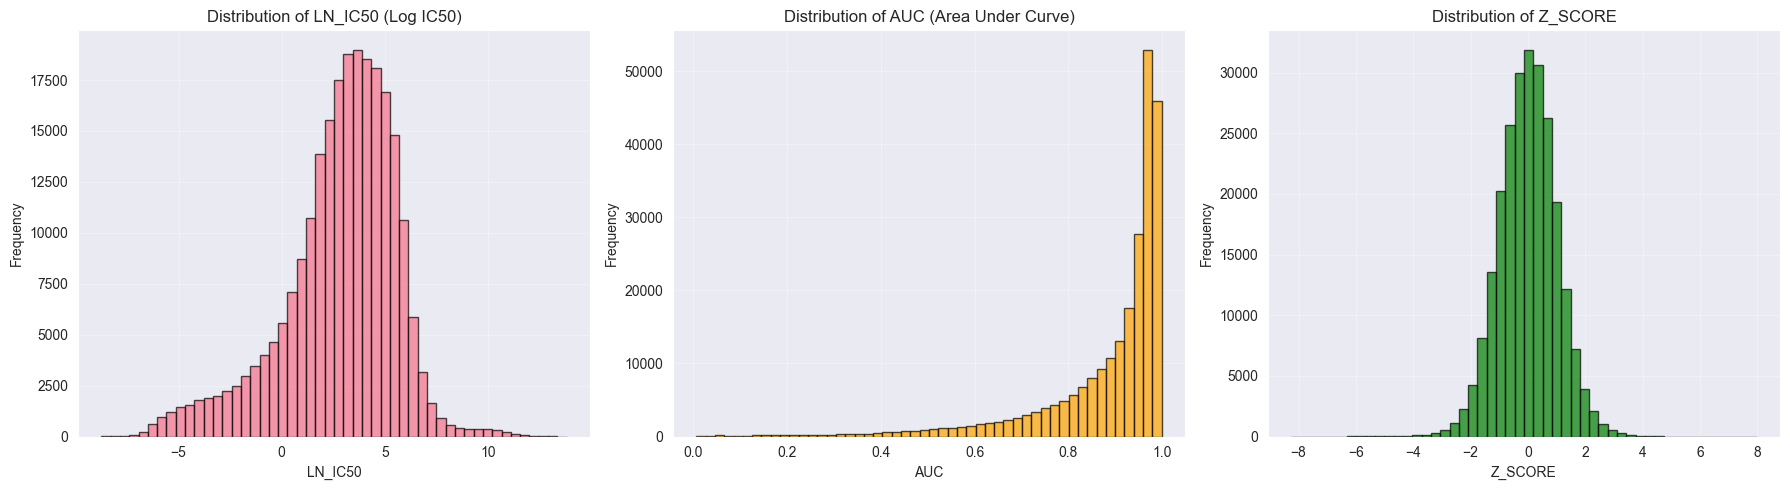

LN_IC50 - Mean: 2.817, Std: 2.762
AUC - Mean: 0.883, Std: 0.147
Z_SCORE - Mean: 0.000, Std: 0.999


In [ ]:
# Visualize target variable distribution (LN_IC50)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LN_IC50 distribution
axes[0].hist(df['LN_IC50'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('LN_IC50')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of LN_IC50 (Log IC50)')
axes[0].grid(True, alpha=0.3)

# AUC distribution
axes[1].hist(df['AUC'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('AUC')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of AUC (Area Under Curve)')
axes[1].grid(True, alpha=0.3)

# Z_SCORE distribution
axes[2].hist(df['Z_SCORE'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xlabel('Z_SCORE')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Z_SCORE')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"LN_IC50 - Mean: {df['LN_IC50'].mean():.3f}, Std: {df['LN_IC50'].std():.3f}")
print(f"AUC - Mean: {df['AUC'].mean():.3f}, Std: {df['AUC'].std():.3f}")
print(f"Z_SCORE - Mean: {df['Z_SCORE'].mean():.3f}, Std: {df['Z_SCORE'].std():.3f}")

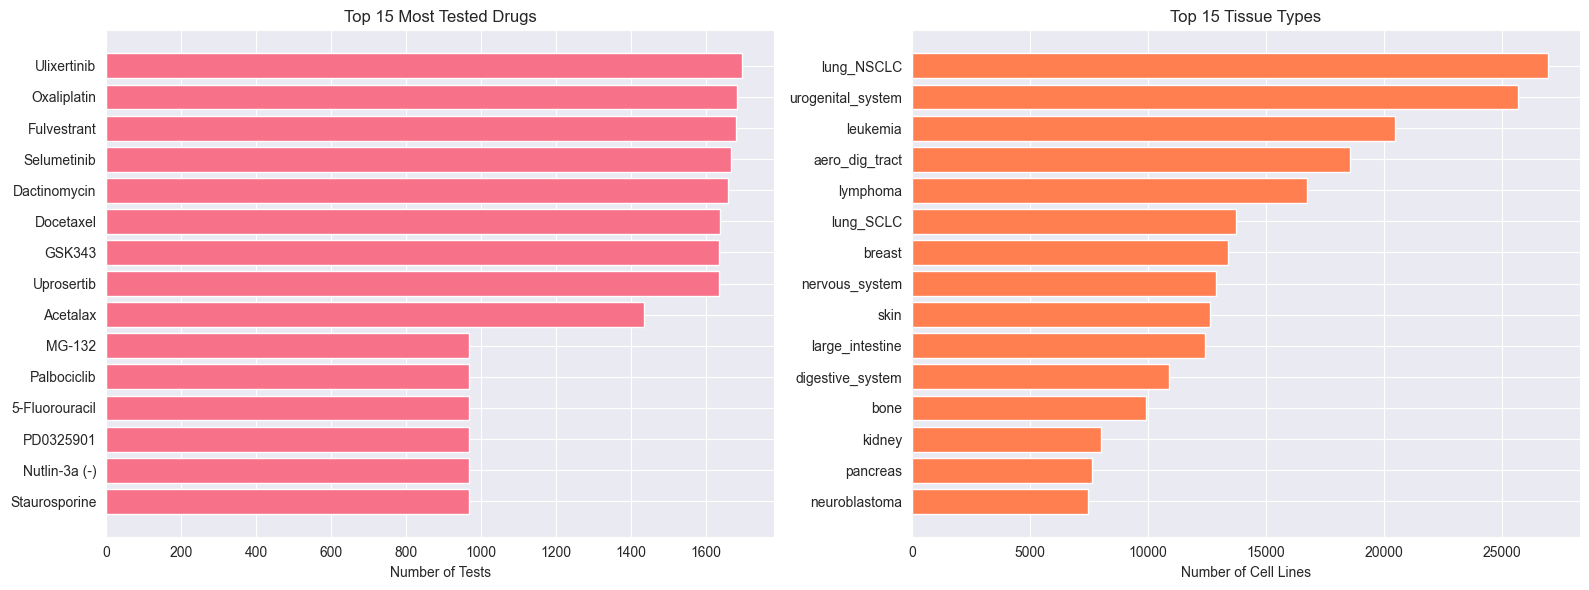

In [ ]:
# Analyze top drugs and cell lines
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 drugs by frequency
top_drugs = df['DRUG_NAME'].value_counts().head(15)
axes[0].barh(range(len(top_drugs)), top_drugs.values)
axes[0].set_yticks(range(len(top_drugs)))
axes[0].set_yticklabels(top_drugs.index)
axes[0].set_xlabel('Number of Tests')
axes[0].set_title('Top 15 Most Tested Drugs')
axes[0].invert_yaxis()

# Top 15 tissue types
top_tissues = df['GDSC Tissue descriptor 1'].value_counts().head(15)
axes[1].barh(range(len(top_tissues)), top_tissues.values, color='coral')
axes[1].set_yticks(range(len(top_tissues)))
axes[1].set_yticklabels(top_tissues.index)
axes[1].set_xlabel('Number of Cell Lines')
axes[1].set_title('Top 15 Tissue Types')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

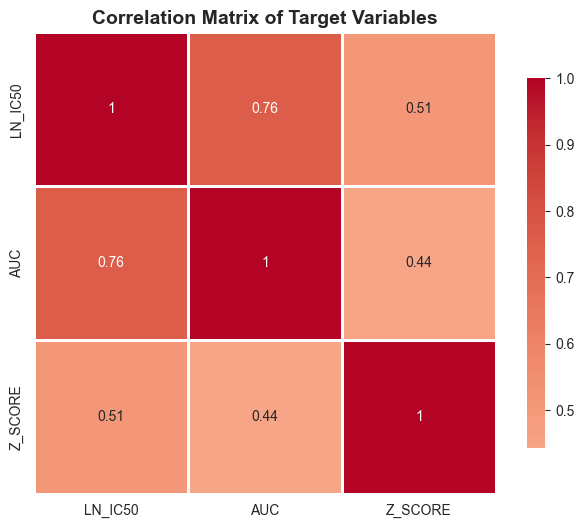


Correlation Matrix:
          LN_IC50       AUC   Z_SCORE
LN_IC50  1.000000  0.762728  0.509209
AUC      0.762728  1.000000  0.442588
Z_SCORE  0.509209  0.442588  1.000000


In [ ]:
# Correlation analysis
numeric_cols = ['LN_IC50', 'AUC', 'Z_SCORE']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Target Variables', fontsize=14, fontweight='bold')
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

## 4. Data Preprocessing and Feature Engineering

In [ ]:
# Create a working copy of the data
df_processed = df.copy()

# Remove rows with missing target variable (LN_IC50)
df_processed = df_processed.dropna(subset=['LN_IC50'])

print(f"Dataset shape after removing missing targets: {df_processed.shape}")

# Select features for the model
# We'll use categorical features and create numerical encodings
categorical_features = [
    'TCGA_DESC',
    'DRUG_NAME',
    'GDSC Tissue descriptor 1',
    'GDSC Tissue descriptor 2',
    'Microsatellite instability Status (MSI)',
    'Screen Medium',
    'Growth Properties',
    'TARGET',
    'TARGET_PATHWAY'
]

# Binary features (Y/N)
binary_features = ['CNA', 'Gene Expression', 'Methylation']

# Target variable
target = 'LN_IC50'

print(f"\nNumber of categorical features: {len(categorical_features)}")
print(f"Number of binary features: {len(binary_features)}")

Dataset shape after removing missing targets: (242035, 19)

Number of categorical features: 9
Number of binary features: 3


In [ ]:
# Encode categorical variables
label_encoders = {}
encoded_features = []

for col in categorical_features:
    if col in df_processed.columns:
        # Fill missing values with 'Unknown'
        df_processed[col] = df_processed[col].fillna('Unknown')
        
        # Create and fit label encoder
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        encoded_features.append(f'{col}_encoded')
        
        print(f"Encoded {col}: {len(le.classes_)} unique values")

# Encode binary features (Y/N to 1/0)
for col in binary_features:
    if col in df_processed.columns:
        df_processed[f'{col}_binary'] = (df_processed[col] == 'Y').astype(int)
        encoded_features.append(f'{col}_binary')

print(f"\nTotal encoded features: {len(encoded_features)}")

Encoded TCGA_DESC: 33 unique values
Encoded DRUG_NAME: 286 unique values
Encoded GDSC Tissue descriptor 1: 20 unique values
Encoded GDSC Tissue descriptor 2: 55 unique values
Encoded Microsatellite instability Status (MSI): 3 unique values
Encoded Screen Medium: 3 unique values
Encoded Growth Properties: 4 unique values
Encoded TARGET: 186 unique values
Encoded TARGET_PATHWAY: 24 unique values

Total encoded features: 12


In [ ]:
# Prepare feature matrix and target
feature_columns = encoded_features
X = df_processed[feature_columns].values
y = df_processed[target].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(feature_columns)}): {feature_columns}")

Feature matrix shape: (242035, 12)
Target shape: (242035,)

Feature columns (12): ['TCGA_DESC_encoded', 'DRUG_NAME_encoded', 'GDSC Tissue descriptor 1_encoded', 'GDSC Tissue descriptor 2_encoded', 'Microsatellite instability Status (MSI)_encoded', 'Screen Medium_encoded', 'Growth Properties_encoded', 'TARGET_encoded', 'TARGET_PATHWAY_encoded', 'CNA_binary', 'Gene Expression_binary', 'Methylation_binary']


## 5. Split Data and Scale Features

In [ ]:
# Data split configuration
TEST_SIZE = 0.2  # 20% for testing
VAL_SIZE = 0.2   # 20% of remaining for validation (results in 64/16/20 split)

print(f"Split configuration: TEST_SIZE={TEST_SIZE}, VAL_SIZE={VAL_SIZE}")
print(f"Final split ratios: ~64% train / ~16% validation / ~20% test")

Split configuration: TEST_SIZE=0.2, VAL_SIZE=0.2
Final split ratios: ~64% train / ~16% validation / ~20% test


In [ ]:
# Split data into training and testing sets (nested split for 64/16/20 train/val/test)
# Keep track of indices for later analysis
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, df_processed.index, test_size=TEST_SIZE, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Further split training set for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE, random_state=42
)

print(f"\nAfter validation split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set size: 193628 samples
Testing set size: 48407 samples
Number of features: 12

After validation split:
Training set: 154902 samples
Validation set: 38726 samples
Test set: 48407 samples


In [ ]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print(f"Training features - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
print(f"Validation features - Mean: {X_val_scaled.mean():.4f}, Std: {X_val_scaled.std():.4f}")
print(f"Test features - Mean: {X_test_scaled.mean():.4f}, Std: {X_test_scaled.std():.4f}")

Feature scaling completed.
Training features - Mean: -0.0000, Std: 1.0000
Validation features - Mean: -0.0032, Std: 1.0051
Test features - Mean: 0.0017, Std: 0.9999


## 6. Build Deep Neural Network Model

In [ ]:
# Model hyperparameters
LAYER_SIZES = [256, 128, 64, 32]
DROPOUT_RATES = [0.4, 0.3, 0.3, 0.2]
LEARNING_RATE = 0.001
BATCH_SIZE = 128
MAX_EPOCHS = 100

print("Hyperparameters configured:")
print(f"  Layer sizes: {LAYER_SIZES}")
print(f"  Dropout rates: {DROPOUT_RATES}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {MAX_EPOCHS}")

Hyperparameters configured:
  Layer sizes: [256, 128, 64, 32]
  Dropout rates: [0.4, 0.3, 0.3, 0.2]
  Learning rate: 0.001
  Batch size: 128
  Max epochs: 100


In [ ]:
def create_deep_model(input_dim, architecture='deep'):
    """
    Create a deep neural network for drug response prediction.
    
    Args:
        input_dim: Number of input features
        architecture: Type of architecture ('simple', 'deep', or 'complex')
    
    Returns:
        Compiled Keras model
    """
    model = keras.Sequential()
    
    if architecture == 'simple':
        # Simple architecture
        model.add(layers.Dense(LAYER_SIZES[2], activation='relu', input_shape=(input_dim,)))
        model.add(layers.Dropout(DROPOUT_RATES[1]))
        model.add(layers.Dense(LAYER_SIZES[3], activation='relu'))
        model.add(layers.Dropout(DROPOUT_RATES[2]))
        model.add(layers.Dense(1))  # Output layer for regression
        
    elif architecture == 'deep':
        # Deep architecture with more layers
        model.add(layers.Dense(LAYER_SIZES[0], activation='relu', input_shape=(input_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(DROPOUT_RATES[0]))
        
        model.add(layers.Dense(LAYER_SIZES[1], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(DROPOUT_RATES[1]))
        
        model.add(layers.Dense(LAYER_SIZES[2], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(DROPOUT_RATES[2]))
        
        model.add(layers.Dense(LAYER_SIZES[3], activation='relu'))
        model.add(layers.Dropout(DROPOUT_RATES[3]))
        
        model.add(layers.Dense(1))  # Output layer for regression
        
    else:  # complex
        # Complex architecture with additional regularization
        model.add(layers.Dense(512, activation='relu', input_shape=(input_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        
        model.add(layers.Dense(LAYER_SIZES[0], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(DROPOUT_RATES[0]))
        
        model.add(layers.Dense(LAYER_SIZES[1], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(DROPOUT_RATES[1]))
        
        model.add(layers.Dense(LAYER_SIZES[2], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(DROPOUT_RATES[2]))
        
        model.add(layers.Dense(LAYER_SIZES[3], activation='relu'))
        model.add(layers.Dropout(DROPOUT_RATES[3]))
        
        model.add(layers.Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mean_squared_error',
        metrics=['mae', 'mse']
    )
    
    return model

# Create the model
model = create_deep_model(X_train_scaled.shape[1], architecture='deep')

# Display model architecture
print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")


MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,385 (189.00 KB)

 Trainable params: 47,489 (185.50 KB)

 Non-trainable params: 896 (3.50 KB)


Total parameters: 48,385


## 7. Train the Model

In [ ]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("Starting model training...\n")

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")

NameError: name 'callbacks' is not defined

## 8. Visualize Training History

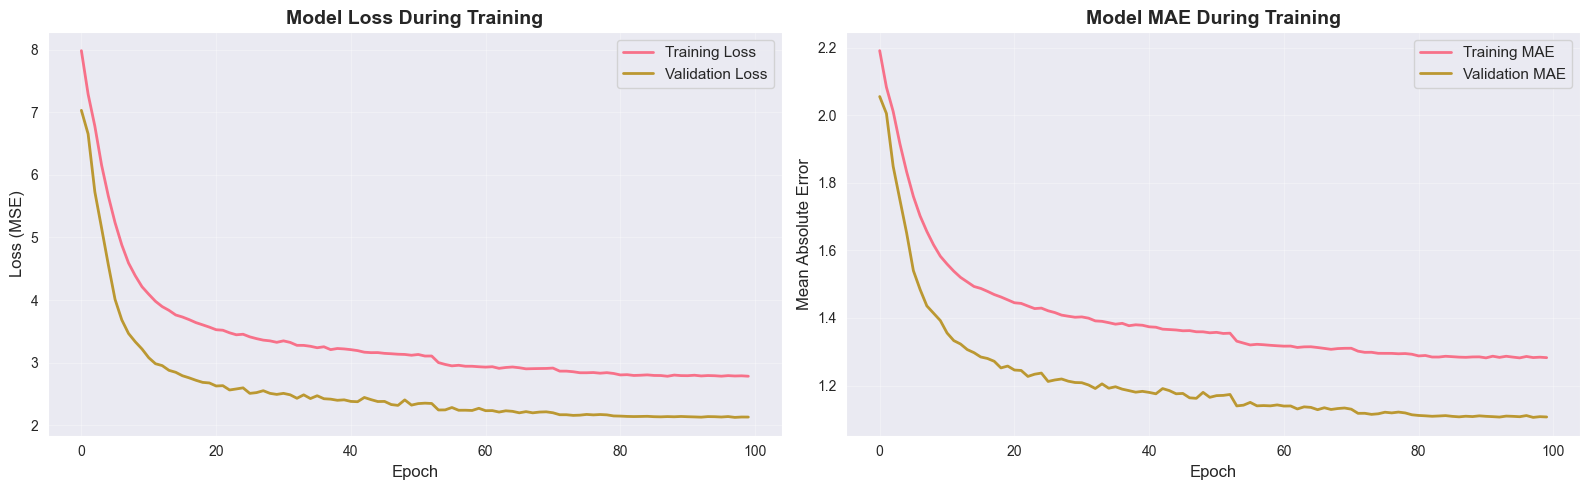


FINAL TRAINING METRICS
Final Training Loss: 2.7833
Final Validation Loss: 2.1310
Final Training MAE: 1.2824
Final Validation MAE: 1.1069
Best Validation Loss: 2.1258
Best Validation MAE: 1.1057


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Mean Absolute Error', fontsize=12)
axes[1].set_title('Model MAE During Training', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "="*70)
print("FINAL TRAINING METRICS")
print("="*70)
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"Best Validation MAE: {min(history.history['val_mae']):.4f}")

## 9. Evaluate Model Performance on Test Set

In [ ]:
# Make predictions on test set
y_pred_train = model.predict(X_train_scaled).flatten()
y_pred_val = model.predict(X_val_scaled).flatten()
y_pred_test = model.predict(X_test_scaled).flatten()

# Calculate metrics
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

print("\n" + "="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)
print("\nTraining Set:")
print(f"  MSE:  {train_mse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")

print("\nValidation Set:")
print(f"  MSE:  {val_mse:.4f}")
print(f"  MAE:  {val_mae:.4f}")
print(f"  R²:   {val_r2:.4f}")

print("\nTest Set:")
print(f"  MSE:  {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*70)

4841/4841 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

MODEL PERFORMANCE METRICS

Training Set:
  MSE:  2.0826
  MAE:  1.0957
  R²:   0.7275

Validation Set:
  MSE:  2.1258
  MAE:  1.1057
  R²:   0.7194

Test Set:
  MSE:  2.1006
  RMSE: 1.4494
  MAE:  1.1004
  R²:   0.7247


## 10. Visualize Predictions

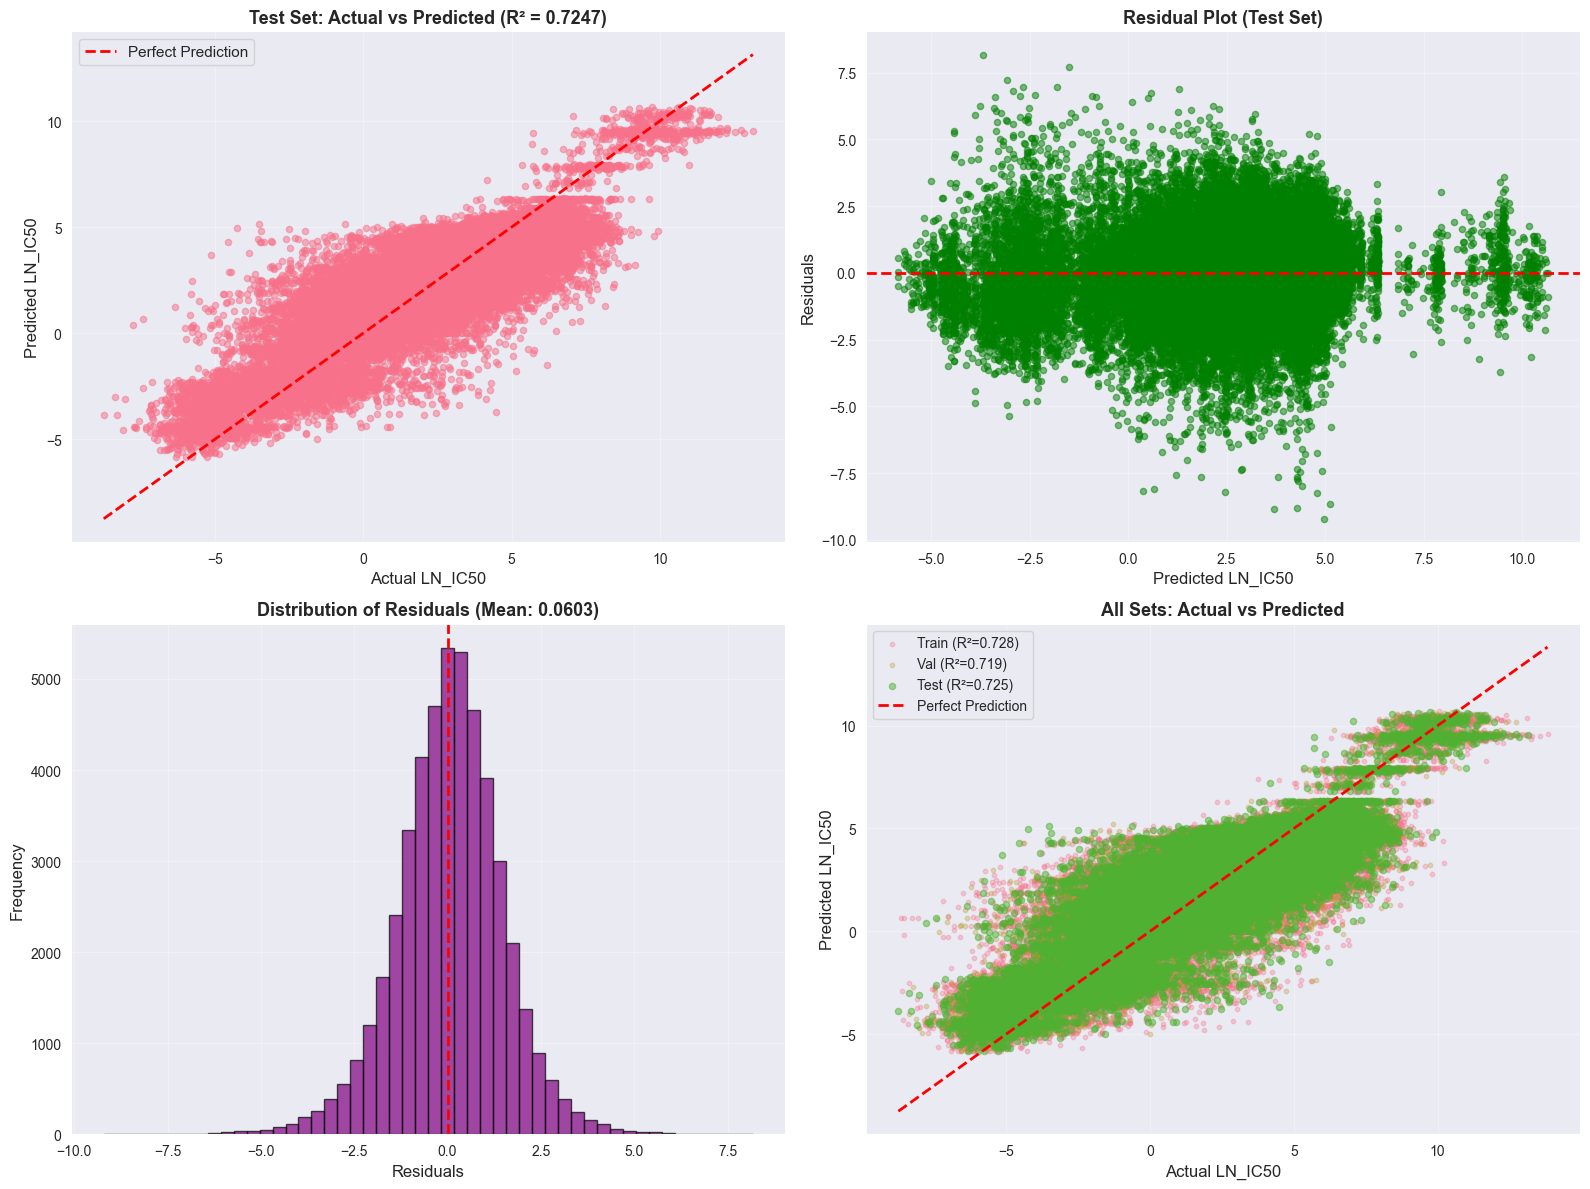

In [ ]:
# Create comprehensive prediction visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot: Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual LN_IC50', fontsize=12)
axes[0, 0].set_ylabel('Predicted LN_IC50', fontsize=12)
axes[0, 0].set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})', 
                     fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Residual plot (Test Set)
residuals_test = y_test - y_pred_test
axes[0, 1].scatter(y_pred_test, residuals_test, alpha=0.5, s=20, c='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted LN_IC50', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)
axes[0, 1].set_title('Residual Plot (Test Set)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Distribution of residuals
axes[1, 0].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title(f'Distribution of Residuals (Mean: {residuals_test.mean():.4f})', 
                     fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot: Training vs Validation vs Test
axes[1, 1].scatter(y_train, y_pred_train, alpha=0.3, s=10, label=f'Train (R²={train_r2:.3f})')
axes[1, 1].scatter(y_val, y_pred_val, alpha=0.3, s=10, label=f'Val (R²={val_r2:.3f})')
axes[1, 1].scatter(y_test, y_pred_test, alpha=0.5, s=20, label=f'Test (R²={test_r2:.3f})')
# Perfect prediction diagonal line
all_y = np.concatenate([y_train, y_val, y_test])
min_val, max_val = all_y.min(), all_y.max()
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual LN_IC50', fontsize=12)
axes[1, 1].set_ylabel('Predicted LN_IC50', fontsize=12)
axes[1, 1].set_title('All Sets: Actual vs Predicted', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Prediction error analysis
error_percentiles = np.percentile(np.abs(residuals_test), [25, 50, 75, 90, 95, 99])

print("\n" + "="*70)
print("PREDICTION ERROR ANALYSIS")
print("="*70)
print(f"Mean Absolute Error: {np.abs(residuals_test).mean():.4f}")
print(f"Median Absolute Error: {np.median(np.abs(residuals_test)):.4f}")
print(f"Std of Residuals: {residuals_test.std():.4f}")
print("\nPercentiles of Absolute Error:")
print(f"  25th: {error_percentiles[0]:.4f}")
print(f"  50th: {error_percentiles[1]:.4f}")
print(f"  75th: {error_percentiles[2]:.4f}")
print(f"  90th: {error_percentiles[3]:.4f}")
print(f"  95th: {error_percentiles[4]:.4f}")
print(f"  99th: {error_percentiles[5]:.4f}")
print("="*70)


PREDICTION ERROR ANALYSIS
Mean Absolute Error: 1.1004
Median Absolute Error: 0.8723
Std of Residuals: 1.4481

Percentiles of Absolute Error:
  25th: 0.4068
  50th: 0.8723
  75th: 1.5276
  90th: 2.3288
  95th: 2.9270
  99th: 4.3197


## 11. Model Interpretation and Feature Importance

In [ ]:
# Analyze predictions by tissue type
# Use the tracked test indices from the train_test_split
test_df = df_processed.loc[test_idx].copy()
test_df['Predicted_LN_IC50'] = y_pred_test
test_df['Actual_LN_IC50'] = y_test
test_df['Prediction_Error'] = np.abs(test_df['Actual_LN_IC50'] - test_df['Predicted_LN_IC50'])

# Average performance by tissue type
tissue_performance = test_df.groupby('GDSC Tissue descriptor 1').agg({
    'Prediction_Error': 'mean',
    'CELL_LINE_NAME': 'count'
}).rename(columns={'CELL_LINE_NAME': 'Count'}).sort_values('Prediction_Error')

# Display top and bottom performing tissue types
print("\n" + "="*70)
print("PERFORMANCE BY TISSUE TYPE")
print("="*70)
print("\nTop 10 Best Predicted Tissue Types:")
print(tissue_performance.head(10))
print("\nTop 10 Worst Predicted Tissue Types:")
print(tissue_performance.tail(10))


PERFORMANCE BY TISSUE TYPE

Top 10 Best Predicted Tissue Types:
                          Prediction_Error  Count
GDSC Tissue descriptor 1                         
soft_tissue                       1.008103   1039
myeloma                           1.010890    904
bone                              1.017214   2038
lymphoma                          1.038571   3305
aero_dig_tract                    1.046675   3663
nervous_system                    1.051219   2569
leukemia                          1.061249   4080
skin                              1.078192   2489
urogenital_system                 1.084979   5170
digestive_system                  1.099276   2160

Top 10 Worst Predicted Tissue Types:
                          Prediction_Error  Count
GDSC Tissue descriptor 1                         
kidney                            1.111123   1574
lung_SCLC                         1.121100   2765
large_intestine                   1.134701   2483
breast                            1.136431   27

In [ ]:
# Average performance by drug
drug_performance = test_df.groupby('DRUG_NAME').agg({
    'Prediction_Error': 'mean',
    'CELL_LINE_NAME': 'count'
}).rename(columns={'CELL_LINE_NAME': 'Count'}).sort_values('Prediction_Error')

print("\n" + "="*70)
print("PERFORMANCE BY DRUG")
print("="*70)
print("\nTop 10 Best Predicted Drugs:")
print(drug_performance.head(10))
print("\nTop 10 Worst Predicted Drugs:")
print(drug_performance.tail(10))


PERFORMANCE BY DRUG

Top 10 Best Predicted Drugs:
                   Prediction_Error  Count
DRUG_NAME                                 
L-Oxonoreleagnine          0.520399    137
PFI3                       0.530102    182
GSK626616AC                0.535140    138
Bicalutamide               0.553737     39
Leflunomide                0.564046    175
Veliparib                  0.573425    197
Cyclophosphamide           0.575717    168
BDILV000379a               0.577600    154
PAK_5339                   0.581216    165
123138                     0.587704    130

Top 10 Worst Predicted Drugs:
                   Prediction_Error  Count
DRUG_NAME                                 
Elesclomol                 1.979147     45
Docetaxel                  1.999840    325
Methotrexate               2.021742    157
Mycophenolic acid          2.158740    146
Epirubicin                 2.281187    175
IGF1R_3801                 2.298841    137
Gemcitabine                2.312635    211
Piperlongumine 

## 12. Save the Model

In [ ]:
# Save the trained model
model.save('drug_response_model.h5')
print("Model saved as 'drug_response_model.h5'")

# Save the scaler for future use
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Feature scaler saved as 'feature_scaler.pkl'")

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("Label encoders saved as 'label_encoders.pkl'\n")
# Save feature columns for future use
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)
print("Feature columns saved as 'feature_columns.pkl'")


Model saved as 'drug_response_model.h5'
Feature scaler saved as 'feature_scaler.pkl'
Label encoders saved as 'label_encoders.pkl'

Feature columns saved as 'feature_columns.pkl'
